In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import requests
import time
import datetime as dt
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]
import networkx as nx #graphs
cwd = os.getcwd()

import seaborn as sns
import matplotlib.pyplot as plt

local imports

In [2]:
from ExMAS.utils import inData as inData
from dotmap import DotMap
from main import make_query, parse_OTP_response
from utils import plot
from utils import get_config
from datetime import timedelta
from scipy import optimize

In [3]:
b11 = pd.read_csv('res/8_9_10/p_SUM(B)_h1.csv').filter(['tw_PT_OD', 'tw_PT_HD', 'u_sh', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM', ], axis = 1)
b12 = pd.read_csv('res/8_9_10/p_SUM(B)_h11.csv').filter(['tw_PT_OD', 'tw_PT_HD', 'u_sh', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM', ], axis = 1)

Bronowice_Małe = pd.concat([b11, b12])
Bronowice_Małe['hub'] = 'Bronowice_Małe'

b21 = pd.read_csv('res/8_9_10/p_SUM(B)_h2.csv').filter(['tw_PT_OD', 'tw_PT_HD', 'u_sh', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM', ], axis = 1)
b22 = pd.read_csv('res/8_9_10/p_SUM(B)_h21.csv').filter(['tw_PT_OD', 'tw_PT_HD', 'u_sh', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM', ], axis = 1)

Bronowice_SKA = pd.concat([b21, b22])
Bronowice_SKA['hub'] = 'Bronowice_SKA'

df= pd.concat([Bronowice_Małe, Bronowice_SKA])

In [5]:
df['dyskomfort pasażerów'] = df.u_SUM_OD
df['prawdopodobieństwo wyboru SUM'] = df.p_SUM
df ['konkurencyjność nowej usługi'] = df['u_PT_OD'] - df['u_SUM_OD']
mu = -0.1
df['wartość dodana'] = np.log(np.exp(mu*df['u_PT_OD'])+np.exp(mu*df['u_SUM_OD'])-np.log(np.exp(mu*df['u_PT_OD'])))
df.reset_index(drop=True, inplace=True)
df.head(3)

,tw_PT_OD,tw_PT_HD,u_sh,u_PT_OD,u_SUM_OD,p_SUM,hub,dyskomfort pasażerów,prawdopodobieństwo wyboru SUM,konkurencyjność nowej usługi,wartość dodana
0,62.0,182.0,2.04050,30.447541,31.826070,0.201245,Bronowice_Małe,31.826070,0.201245,-1.378528,1.142259
1,281.0,207.0,0.62500,36.861213,30.243486,0.998665,Bronowice_Małe,30.243486,0.998665,6.617727,1.324360
2,0.0,2.0,5.63925,7.006284,15.890837,0.000138,Bronowice_Małe,15.890837,0.000138,-8.884554,0.337196


In [6]:
df.groupby('hub').mean()

,tw_PT_OD,tw_PT_HD,u_sh,u_PT_OD,u_SUM_OD,p_SUM,dyskomfort pasażerów,prawdopodobieństwo wyboru SUM,konkurencyjność nowej usługi,wartość dodana
hub,,,,,,,,,,
Bronowice_Małe,116.515409,39.137131,3.786935,15.005419,16.602235,0.347077,16.602235,0.347077,-1.607794,0.659685
Bronowice_SKA,116.579171,36.205696,4.281716,15.007145,16.828358,0.321363,16.828358,0.321363,-1.836068,0.657737


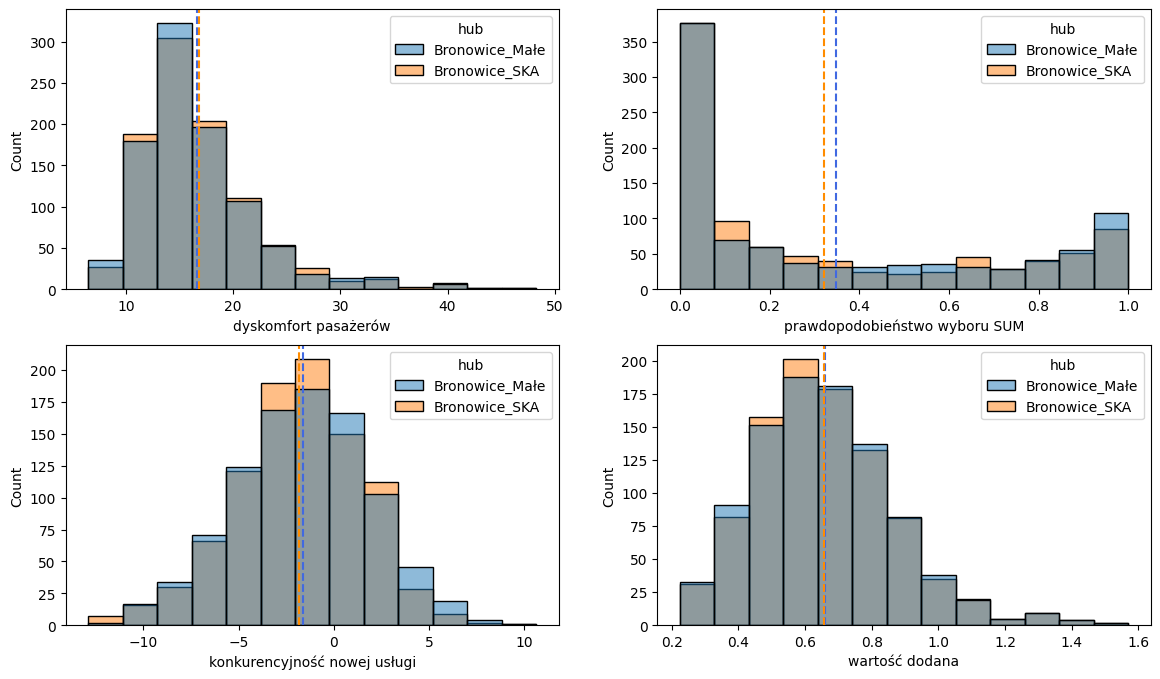

In [8]:
d = df.groupby('hub').mean()
fig, axes = plt.subplots(2,2, figsize=(14,8))
axes = axes.flatten()

ax=axes[0]
ax = sns.histplot(data = df, x = df['dyskomfort pasażerów'], hue = 'hub', bins = 13, ax = ax)
ax.axvline(d.loc['Bronowice_Małe', 'dyskomfort pasażerów'], linestyle='--', color="royalblue")
ax.axvline(d.loc['Bronowice_SKA', 'dyskomfort pasażerów'], linestyle='--', color="darkorange")

ax=axes[1]
to_plot = df
sns.histplot(data = to_plot, x = df['prawdopodobieństwo wyboru SUM'], hue = 'hub', bins = 13, ax = ax)
ax.axvline(d.loc['Bronowice_Małe', 'prawdopodobieństwo wyboru SUM'], linestyle='--', color="royalblue")
ax.axvline(d.loc['Bronowice_SKA', 'prawdopodobieństwo wyboru SUM'], linestyle='--', color="darkorange")

ax=axes[2]
ax = sns.histplot(data = df, x = df['konkurencyjność nowej usługi'], hue = 'hub', bins = 13, ax = ax)
ax.axvline(d.loc['Bronowice_Małe', 'konkurencyjność nowej usługi'], linestyle='--', color="royalblue")
ax.axvline(d.loc['Bronowice_SKA', 'konkurencyjność nowej usługi'], linestyle='--', color="darkorange")

ax=axes[3]
ax = sns.histplot(data = df, x = df['wartość dodana'], hue = 'hub', bins = 13, ax = ax)
ax.axvline(d.loc['Bronowice_Małe', 'wartość dodana'], linestyle='--', color="royalblue")
ax.axvline(d.loc['Bronowice_SKA', 'wartość dodana'], linestyle='--', color="darkorange")

# plt.savefig('res/h1-h2(2).jpg',  bbox_inches='tight', dpi=200)